In [ ]:
import sys
from datetime import datetime

from catppuccin.extras.rich_ctp import mocha
from rich import pretty
from rich.console import Console

pretty.install()

if ".." not in sys.path:
    sys.path.insert(0, "..")

from src.config.settings import get_settings
from src.utils.logger import create_logger

console = Console(theme=mocha)
settings = get_settings()
logger = create_logger(path=settings.paths.logs_dir)
logger.debug(f"settings loaded as \n{settings.model_dump_json(indent=2)}")

06:09 PM | 1830558465.L:19  | DEBUG     | settings loaded as 
{
  "models": {
    "hf": {
      "chat": "meta-llama/Llama-3.2-3B-Instruct:together",
      "reasoning": "zai-org/GLM-4.7-Flash:novita",
      "structured_output": "Qwen/Qwen3-Coder-30B-A3B-Instruct:ovhcloud",
      "embedding_snowflake": "Snowflake/snowflake-arctic-embed-l-v2.0",
      "embedding_specter": "allenai/specter2_base",
      "encoder": "m3rg-iitd/matscibert",
      "reranker": "Qwen/Qwen3-Reranker-0.6B",
      "router": "openai/gpt-oss-20b:together"
    },
    "nebius": {
      "reasoning": "zai-org/GLM-4.5-Air",
      "tool_user": "Qwen/Qwen3-30B-A3B-Instruct-2507",
      "chat": "meta-llama/Meta-Llama-3.1-8B-Instruct-fast",
      "embedding_baai_bge": "BAAI/bge-multilingual-gemma2",
      "router": "openai/gpt-oss-20b"
    }
  },
  "paths": {
    "base_dir": "C:\\Users\\70086503\\code\\lattice",
    "data_dir": "C:\\Users\\70086503\\code\\lattice\\data",
    "logs_dir": "C:\\Users\\70086503\\code\\lattice\\lo

In [2]:
from typing import Annotated, Dict, List, Optional, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.types import interrupt
from pydantic import BaseModel, Field
from pydantic.json_schema import SkipJsonSchema

In [3]:
from src.prompts.system import PRIMER_SYSTEM_PROMPT
from src.prompts.structured_outputs import RESEARCH_PLAN_STRUCTURED_OUTPUT_EXTRACTOR

version = "0.0.1-alpha"

In [4]:
class ResearchQuestion(BaseModel):
    question_text: str = Field(default_factory=str)
    research_subquestions: Optional[List[str]] = Field(default_factory=list)


class ResearchPlan(BaseModel):
    created_at: SkipJsonSchema[datetime] = Field(
        default_factory=datetime.now,
    )
    title: str = Field(default_factory=str)
    summary: str = Field(default_factory=str)
    objectives: List[str] = Field(default_factory=list)
    keywords: Optional[List[str]] = Field(default_factory=list)
    research_questions: List[ResearchQuestion] = Field(default_factory=list)
    next_steps: List[str] = Field(default_factory=list)
    further_clarifications_required: List[str] = Field(default_factory=list)
    other_ai_message: List[str] = Field(default_factory=str)

    def to_markdown(self) -> str:
        """Converts the ResearchPlan object into a structured Markdown document."""
        timestamp = self.created_at.strftime("%Y-%m-%d %H:%M")

        title = self.title.lstrip("# ").strip() or "Untitled Research Plan"
        md = f"# {title}\nAuthor: Lattice, {timestamp}\n\n"

        # Summary Section
        if self.summary.strip():
            md += f"## Summary\n{self.summary.strip()}\n\n"

        # Objectives Section
        objectives = [o.strip() for o in self.objectives if o.strip()]
        if objectives:
            md += "## Objectives\n"
            for obj in objectives:
                md += f"- {obj}\n"
            md += "\n"

        # Keywords Section
        keywords = [k.strip() for k in self.keywords or [] if k.strip()]
        if keywords:
            md += "## Keywords\n"
            md += ", ".join(f"`{k}`" for k in keywords) + "\n\n"

        # Research Questions Section
        questions = [
            rq
            for rq in self.research_questions
            if rq.question_text.strip()
            or any(s.strip() for s in rq.research_subquestions or [])
        ]

        if questions:
            md += "## Research Questions\n"
            for i, rq in enumerate(questions, 1):
                q_text = rq.question_text.lstrip("# ").strip()
                md += f"### **RQ{i}**: {q_text}\n"

                for j, sub in enumerate(rq.research_subquestions or [], 1):
                    sub_text = sub.strip()
                    if sub_text:
                        md += f"- **Sub-RQ{j}**: {sub_text}\n"
                md += "\n"

        # Next Steps
        next_steps = [s.strip() for s in self.next_steps if s.strip()]
        if next_steps:
            md += "## Next Steps\n"
            for i, step in enumerate(next_steps, 1):
                md += f"{i}. {step}\n"
            md += "\n"

        # Further Clarifications Required
        clarifications = [
            c.strip() for c in self.further_clarifications_required if c.strip()
        ]
        if clarifications:
            md += "## Further Clarifications Required\n"
            for i, item in enumerate(clarifications, 1):
                md += f"{i}. {item}\n"
            md += "\n"

        return md

    def is_empty(self) -> bool:
        def has_text(s: str | None) -> bool:
            return bool(s and s.strip())

        # Title or summary
        if has_text(self.title):
            return False
        if has_text(self.summary):
            return False

        # Objectives
        if any(has_text(o) for o in self.objectives or []):
            return False

        # Keywords
        if any(has_text(k) for k in self.keywords or []):
            return False

        # Research questions and subquestions
        for rq in self.research_questions or []:
            if has_text(rq.question_text):
                return False
            if any(has_text(s) for s in rq.research_subquestions or []):
                return False

        # Next steps
        if any(has_text(s) for s in self.next_steps):
            return False

        # Further clarifications
        if any(has_text(c) for c in self.further_clarifications_required):
            return False

        return True

In [5]:
research_plan_template = ResearchPlan(
    title="Title",
    summary="Summary",
    objectives=["objective1", "objective2"],
    keywords=["keyword1", "keyword2"],
    research_questions=[
        ResearchQuestion(
            question_text="ResearchQuestion1",
            research_subquestions=["ResearchSubQuestion1", "ResearchSubQuestion2"],
        )
    ],
    further_clarifications_required=[
        "further clarification 1",
        "further clarification 2",
    ],
    next_steps=["step 1", "step 2"],
)

In [6]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    research_plan: Optional[ResearchPlan]
    is_plan_approved_by_user: Optional[bool]

# Design the graph

In [9]:
chat_llm = ChatOpenAI(
    model=settings.models.nebius.chat,
    base_url=settings.env.NEBIUS_API_ENDPOINT,
    api_key=settings.env.NEBIUS_API_KEY,
    max_completion_tokens=8192,
    temperature=0.0,
    top_p=0.7,
)
structured_research_plan_llm = ChatOpenAI(
    model=settings.models.hf.structured_output,
    base_url=settings.env.HF_API_ENDPOINT,
    api_key=settings.env.HF_API_KEY,
    max_completion_tokens=8192,
    temperature=0.0,
    top_p=1,
).with_structured_output(ResearchPlan, include_raw=True, method="json_mode")
reasoning_llm = ChatOpenAI(
    model=settings.models.hf.reasoning,
    base_url=settings.env.HF_API_ENDPOINT,
    api_key=settings.env.HF_API_KEY,
    max_completion_tokens=8192,
    temperature=0.0,
    top_p=0.7,
)

In [10]:
my_message = HumanMessage(content="how are you?")
response = chat_llm.invoke([my_message])

In [11]:
response


AIMessage(
    content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to help with any questions or tasks you have! How can I assist you today?",
    additional_kwargs={'refusal': None},
    response_metadata={
        'token_usage': {
            'completion_tokens': 45,
            'prompt_tokens': 14,
            'total_tokens': 59,
            'completion_tokens_details': None,
            'prompt_tokens_details': None
        },
        'model_provider': 'openai',
        'model_name': 'meta-llama/Meta-Llama-3.1-8B-Instruct-fast',
        'system_fingerprint': None,
        'id': 'chatcmpl-94500bb5f7054384b29201a504f46e6a',
        'finish_reason': 'stop',
        'logprobs': None
    },
    id='lc_run--019c28ab-2d7f-7ab3-b00f-d655c966c596-0',
    tool_calls=[],
    invalid_tool_calls=[],
    usage_metadata={
        'input_tokens': 14,
        'output_tokens': 45,
        'total_tokens': 59,
        'i

In [12]:
from langchain_core.messages import convert_to_openai_messages

In [14]:
convert_to_openai_messages(my_message)

{'role': 'user', 'content': 'how are you?'}

In [34]:
def accumulate_usage(total: dict, new: dict):
    if not new:
        return total

    for key, value in new.items():
        if isinstance(value, dict):
            total.setdefault(key, {})
            accumulate_usage(total[key], value)
        elif isinstance(value, (int, float)):
            total[key] = total.get(key, 0) + value

    return total

In [ ]:
def chat_and_planner_node(state: AgentState) -> AgentState | Dict:
    logger.debug("entering chat_and_planner_node.")
    SYSTEM_PROMPT = PRIMER_SYSTEM_PROMPT.format(
        date=datetime.now().strftime("%B %Y"), version=version
    )
    full_context = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    total_usage_metadata = {}
    total_token_usage = {}
    # ask chat llm if its ready to generate research plan (yes) or needs more clarifications (no)
    # if yes, use reasoning llm to create the plan
    # and use structured llm to parse the output
    # if no, yes chat llm to keep refining
    plain_text_response = chat_llm.invoke(full_context)
    accumulate_usage(
        total_usage_metadata,
        getattr(plain_text_response, "usage_metadata", {}),
    )
    accumulate_usage(
        total_token_usage,
        plain_text_response.response_metadata.get("token_usage", {}),
    )
    retries = 0
    parsed = None
    while retries < 3:
        messages = [
            SystemMessage(
                content=RESEARCH_PLAN_STRUCTURED_OUTPUT_EXTRACTOR.format(
                    schema=str(research_plan_template.model_json_schema()),
                    example=research_plan_template.to_markdown()
                    + "\nRETURN ONLY A JSON OBJECT",
                )
            ),
            plain_text_response,
        ]
        structured_output = structured_research_plan_llm.invoke(messages)
        # break the structured output into raw, parsed, and parsing error
        raw = structured_output["raw"]
        parsed = structured_output["parsed"]
        error = structured_output["parsing_error"]
        accumulate_usage(
            total_usage_metadata,
            getattr(raw, "usage_metadata", {}),
        )

        accumulate_usage(
            total_token_usage,
            raw.response_metadata.get("token_usage", {}),
        )
        if not error:
            break
        logger.error("Ran into some error while parsing structured out. Retrying.")
        retries += 1
    if retries == 3:
        logger.error(
            "Max retries of 3 reached but model still did not generate valid output."
        )
        return {"messages": AIMessage(content="")}
    plain_text_response.usage_metadata = total_usage_metadata
    plain_text_response.response_metadata["token_usage"] = total_token_usage
    return {
        "messages": plain_text_response,
        "research_plan": parsed,
    }


def user_review_and_feedback_node(state: AgentState) -> AgentState | Dict:
    """this node recieves the research plan that has been properly generated. now its time to ask the user for feedback or approve the plan.

    Values expected in user_feedback:
    - human: str
    - is_approved: bool

    Args:
        state (AgentState): the graph state

    Returns:
        AgentState | Dict: the returned value
    """
    logger.debug("entering user_review_and_feedback_node")
    # else if the plan is not approved ask for feedback or approval
    user_feedback = interrupt(
        {
            "interrupt_id": "user_review_and_feedback_node",
            "interrupt_message": "",
            "messages": state["messages"],
            "research_plan": (
                state["research_plan"] if state["research_plan"] else str(None)
            ),
        }
    )
    if user_feedback.get("is_approved", False):
        # this needs to go to survey again
        return {
            "messages": [
                SystemMessage(
                    content="The research plan has been approved by the user with feedback."
                ),
                HumanMessage(content=user_feedback.get("human", "")),
            ],
            "is_plan_approved_by_user": True,
        }
    else:
        # so the user did not approve. append the feedback and send back to the planner
        return {
            "messages": [
                SystemMessage(
                    content="The user has feedback/clarifications/suggestions regarding the research plan."
                ),
                HumanMessage(content=user_feedback.get("human", "")),
            ],
            "is_plan_approved_by_user": False,
        }


def edit_plan_or_survey_router(state: AgentState) -> AgentState | str:
    logger.debug("entering edit_plan_or_survey_router")
    if state["is_plan_approved_by_user"]:
        logger.info("Plan approved. Proceeding with survey.")
        return "survey"
    else:
        logger.info("Plan not approved. Reviewing.")
        return "plan"


def survey_node(state: AgentState) -> AgentState | Dict:
    logger.debug("Entering survey_node")
    return {"messages": AIMessage(content="Surveying...")}

In [37]:
graph = StateGraph(AgentState)
graph.add_node("chat_and_planner_node", chat_and_planner_node)
graph.add_node("user_review_and_feedback_node", user_review_and_feedback_node)
graph.add_node("survey_node", survey_node)
graph.add_edge(START, "chat_and_planner_node")
graph.add_edge("chat_and_planner_node", "user_review_and_feedback_node")
graph.add_conditional_edges(
    "user_review_and_feedback_node",
    edit_plan_or_survey_router,
    {"survey": "survey_node", "plan": "chat_and_planner_node"},
)
graph.add_edge("survey_node", END)
checkpointer = MemorySaver()
agent = graph.compile(checkpointer=checkpointer)

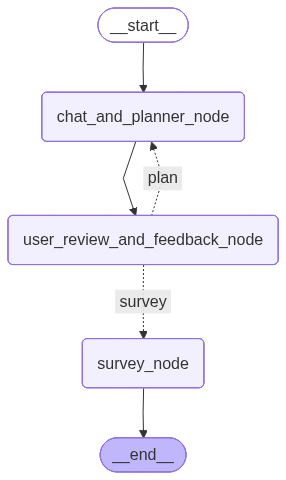

In [38]:
agent

In [40]:
config = {"configurable": {"thread_id": "thread-2"}}

In [41]:
response = agent.invoke(
    {"messages": HumanMessage(content="who are you?")}, config=config
)

10:24 AM | 3960978833.L:2   | DEBUG     | entering chat_and_planner_node.
10:24 AM | 3960978833.L:79  | DEBUG     | entering user_review_and_feedback_node


In [43]:
for intr in response["__interrupt__"]:
    if intr.value["interrupt_id"] == "user_review_and_feedback_node":
        # rprint(intr.value)
        rprint(f"AI: {intr.value['messages'][-1].content}")
        rprint("plan:\n")
        rprint(intr.value["research_plan"].is_empty())

AI: I am Lattice, a Literature Survey Agent. My mission is to assist a doctoral student in conducting a literature 
survey in a given field. I am designed to provide a structured approach to literature searching, help with 
organizing research, and offer guidance on how to effectively analyze and synthesize existing research. I am here 
to support you in your research endeavors.

plan:

True

In [ ]:
response = agent.invoke(
    Command(
        resume={
            "human": "Can you help me create a research plan on thin film doping of ZnO?",
            "is_approved": False,
        }
    ),
    config=config,
)

In [13]:
state = AgentState()
state

{}

In [14]:
SYSTEM_PROMPT = PRIMER_SYSTEM_PROMPT.format(
    date=datetime.now().strftime("%B %Y"), version=version
)
full_context = [SystemMessage(content=SYSTEM_PROMPT), HumanMessage("who are you?")]
plain_text_response = llm.invoke(full_context)

In [15]:
plain_text_response


AIMessage(
    content='I am Lattice, a Literature Survey Agent. My mission is to assist doctoral students in conducting a literature survey in a given field. I am a research assistant designed to provide guidance and support throughout the literature survey process.',
    additional_kwargs={'refusal': None},
    response_metadata={
        'token_usage': {
            'completion_tokens': 45,
            'prompt_tokens': 1700,
            'total_tokens': 1745,
            'completion_tokens_details': None,
            'prompt_tokens_details': None,
            'cached_tokens': 0
        },
        'model_provider': 'openai',
        'model_name': 'meta-llama/Llama-3.2-3B-Instruct-Turbo',
        'system_fingerprint': None,
        'id': 'oVrRqzq-4msxKE-9c7f975a0beb7fae',
        'finish_reason': 'stop',
        'logprobs': None
    },
    id='lc_run--019c2203-d363-7c30-9382-0ab1c874bf21-0',
    tool_calls=[],
    invalid_tool_calls=[],
    usage_metadata={
        'input_tokens': 170

In [16]:
state.update({"messages": [HumanMessage(content="who are you?"), plain_text_response]})
full_context = (
    [SystemMessage(content=SYSTEM_PROMPT)]
    + state["messages"]
    + [
        HumanMessage(
            content="Can you help me conduct a survey on thin film doping methods and diode designs for doping on ZnO?"
        )
    ]
)
plain_text_response2 = llm.invoke(full_context)
plain_text_response2.pretty_print()

================================== Ai Message ==================================

I can help you conduct a literature survey on thin film doping methods and diode designs for doping on ZnO.

To get started, let's break down the scope of the survey. What specific aspects of thin film doping methods and diode designs would you like to focus on? For example, would you like to explore:

1. **Doping techniques**: PVD, CVD, MBE, or other methods for introducing impurities into ZnO thin films?
2. **Diode designs**: Different architectures, such as p-n junctions, Schottky diodes, or ohmic contacts?
3. **Material properties**: How do different doping methods affect the electrical and optical properties of ZnO?
4. **Applications**: What are the potential applications of ZnO-based diodes in fields like optoelectronics, sensors, or energy harvesting?

Please let me know which areas you'd like to explore, and I'll help you generate a research plan and provide guidance on the literature.

Also, woul

In [17]:
state.update(
    {
        "messages": [
            HumanMessage(content="who are you?"),
            plain_text_response,
            HumanMessage(
                content="Can you help me conduct a survey on thin film doping methods and diode designs for doping on ZnO?"
            ),
            plain_text_response2,
        ]
    }
)
message = HumanMessage(
    content="Answers:1. i would like to explore different doping techniques for a pn junction diode. I am not interested in ZnO's properties for now. I am also not interested in its applications."
)
full_context = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"] + [message]
plain_text_response3 = llm.invoke(full_context)
state["messages"].extend([message, plain_text_response3])
plain_text_response3.pretty_print()

================================== Ai Message ==================================

Let's focus on the doping techniques for a p-n junction diode in ZnO.

Here's a research plan to get us started:

**Title:** Investigation of Doping Techniques for p-n Junction Diodes in ZnO

**Keywords:** ZnO, p-n junction, doping techniques, PVD, CVD, MBE, impurity introduction

**Summary:** This research aims to explore different doping techniques for creating p-n junction diodes in ZnO. We will investigate the effects of various doping methods on the electrical properties of the diodes.

**Research Questions:**

1. What are the most effective doping techniques for creating p-n junction diodes in ZnO?
2. How do different doping methods affect the electrical properties of the diodes, such as current-voltage characteristics and carrier concentration?
3. What are the advantages and limitations of each doping technique?

**Research Questions Sub-questions:**

1.1. What are the effects of PVD, CVD, and MBE 

In [18]:
messages = [
    SystemMessage(
        content=RESEARCH_PLAN_STRUCTURED_OUTPUT_EXTRACTOR.format(
            schema=str(research_plan_template.model_json_schema()),
            example=research_plan_template.to_markdown()
            + "\nRETURN ONLY A JSON OBJECT",
        )
    ),
    plain_text_response3,
]
structured_llm = ChatOpenAI(
    model=settings.models.hf.structured_output,
    base_url=settings.env.HF_API_ENDPOINT,
    api_key=settings.env.HF_API_KEY,
    max_completion_tokens=8000,
    temperature=0.0,
    top_p=1.0,
).with_structured_output(ResearchPlan, method="json_mode", include_raw=True)
parsed3 = structured_llm.invoke(messages)
rprint(parsed3["parsed"].to_markdown())
rprint(parsed3["raw"].usage_metadata)

# Investigation of Doping Techniques for p-n Junction Diodes in ZnO
Author: Lattice, 2026-02-03 11:11

## Summary
This research aims to explore different doping techniques for creating p-n junction diodes in ZnO. We will 
investigate the effects of various doping methods on the electrical properties of the diodes.

## Objectives
- Explore different doping techniques for creating p-n junction diodes in ZnO
- Investigate the effects of various doping methods on the electrical properties of the diodes

## Keywords
`ZnO`, `p-n junction`, `doping techniques`, `PVD`, `CVD`, `MBE`, `impurity introduction`

## Research Questions
### **RQ1**: What are the most effective doping techniques for creating p-n junction diodes in ZnO?
- **Sub-RQ1**: What are the effects of PVD, CVD, and MBE on the incorporation of impurities into ZnO?
- **Sub-RQ2**: How do different doping concentrations affect the electrical properties of the diodes?
- **Sub-RQ3**: What are the effects of post-deposition annealing on the doping profiles and electrical properties 
of the diodes?

### **RQ2**: How do different doping methods affect the electrical properties of the diodes, such as 
current-voltage characteristics and carrier concentration?

### **RQ3**: What are the advantages and limitations of each doping technique?

## Next Steps
1. Review existing literature on doping techniques for p-n junction diodes in ZnO.
2. Investigate the effects of different doping methods on the electrical properties of the diodes.
3. Analyze the advantages and limitations of each doping technique.

{
    'input_tokens': 1132,
    'output_tokens': 412,
    'total_tokens': 1544,
    'input_token_details': {},
    'output_token_details': {}
}